In [2]:
import pandas as pd

df = pd.read_csv('housing-indexes.csv', skiprows=11, names=['city', 'date', 'total', 'total_symbol', 'houses', 'houses_symbol', 'land', 'land_symbol'], skipfooter=25)
df['city'] = df['city'].fillna(method='ffill')
df['month'] = df['date'].str.split().str[0]
df['year'] = df['date'].str.split().str[1]
df['tor_van'] = df['city'].isin(['Vancouver, British Columbia', 'Toronto, Ontario 10'])
_ = df.drop(['year', 'city'], 1).isna().groupby([df.year, df.city], sort=False)['total', 'houses', 'land'].sum().reset_index()
_.loc[_.total > 0].to_csv('missing.csv')


/tmp/ipykernel_14815/791215020.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('housing-indexes.csv', skiprows=11, names=['city', 'date', 'total', 'total_symbol', 'houses', 'houses_symbol', 'land', 'land_symbol'], skipfooter=25)
/tmp/ipykernel_14815/791215020.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  _ = df.drop(['year', 'city'], 1).isna().groupby([df.year, df.city], sort=False)['total', 'houses', 'land'].sum().reset_index()
/tmp/ipykernel_14815/791215020.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  _ = df.drop(['year', 'city'], 1).isna().groupby([df.year, df.city], sort=False)['total', 'houses', 'land'].sum().reset_index()


In [3]:

df = df.dropna(subset='houses')

tor_van = df.loc[df['city'].isin(['Vancouver, British Columbia', 'Toronto, Ontario 10'])] 
no_tor_van = df.loc[~df['city'].isin(['Vancouver, British Columbia', 'Toronto, Ontario 10'])] 

<Axes: xlabel='year'>

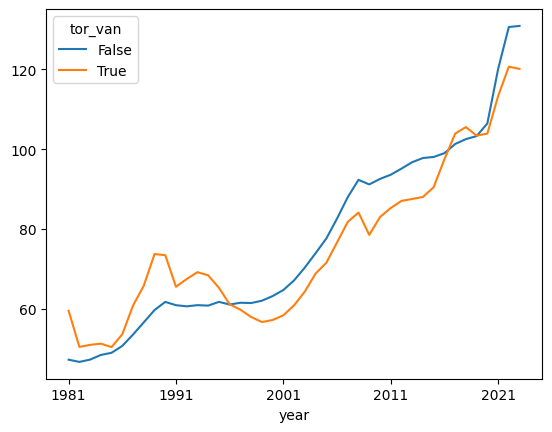

In [4]:
df[['year', 'houses', 'tor_van']].groupby(['year', 'tor_van'], as_index=False).mean().pivot(index='year', columns='tor_van', values='houses').plot()

<Axes: xlabel='year'>

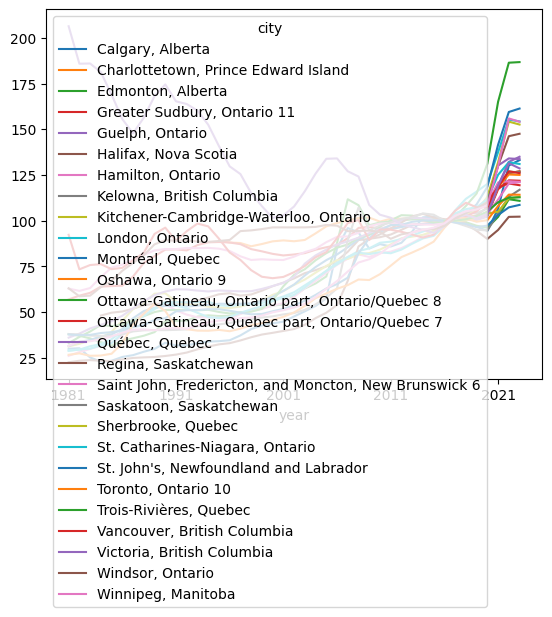

In [5]:
df[['year', 'houses', 'city']].groupby(['year', 'city'], as_index=False).mean().pivot(index='year', columns='city', values='houses').plot()

In [6]:
cities = df.groupby(['city', 'year'], as_index=False)['houses'].mean()
cities['province'] = cities['city'].str.split(', ').str[-1]
cities['city2'] = cities['city'].str.split(', ').str[0]
cities['province'] = cities['province'].replace(['Ontario 11', 'Ontario 9', 'Ontario/Quebec 8', 'Ontario/Quebec 7', 'New Brunswick 6', 'Ontario 10'],
                           ['Ontario', 'Ontario', 'Ontario/Quebec', 'Ontario/Quebec', 'New Brunswick', 'Ontario'])
cities['city_prov'] = cities['city2'] + ', ' + cities['province']
cities = cities.sort_values(['province', 'city', 'year'])
# cities = cities.loc[cities['year'] > '2010']

# Reindex houses so that the value for 2012 is 100 for each city
# for city in cities['city'].unique():
#     base_value = cities.loc[(cities['city'] == city) & (cities['year'] == '2000'), 'houses'].values[0]
#     cities.loc[cities['city'] == city, 'houses'] = cities.loc[cities['city'] == city, 'houses'] / base_value * 100


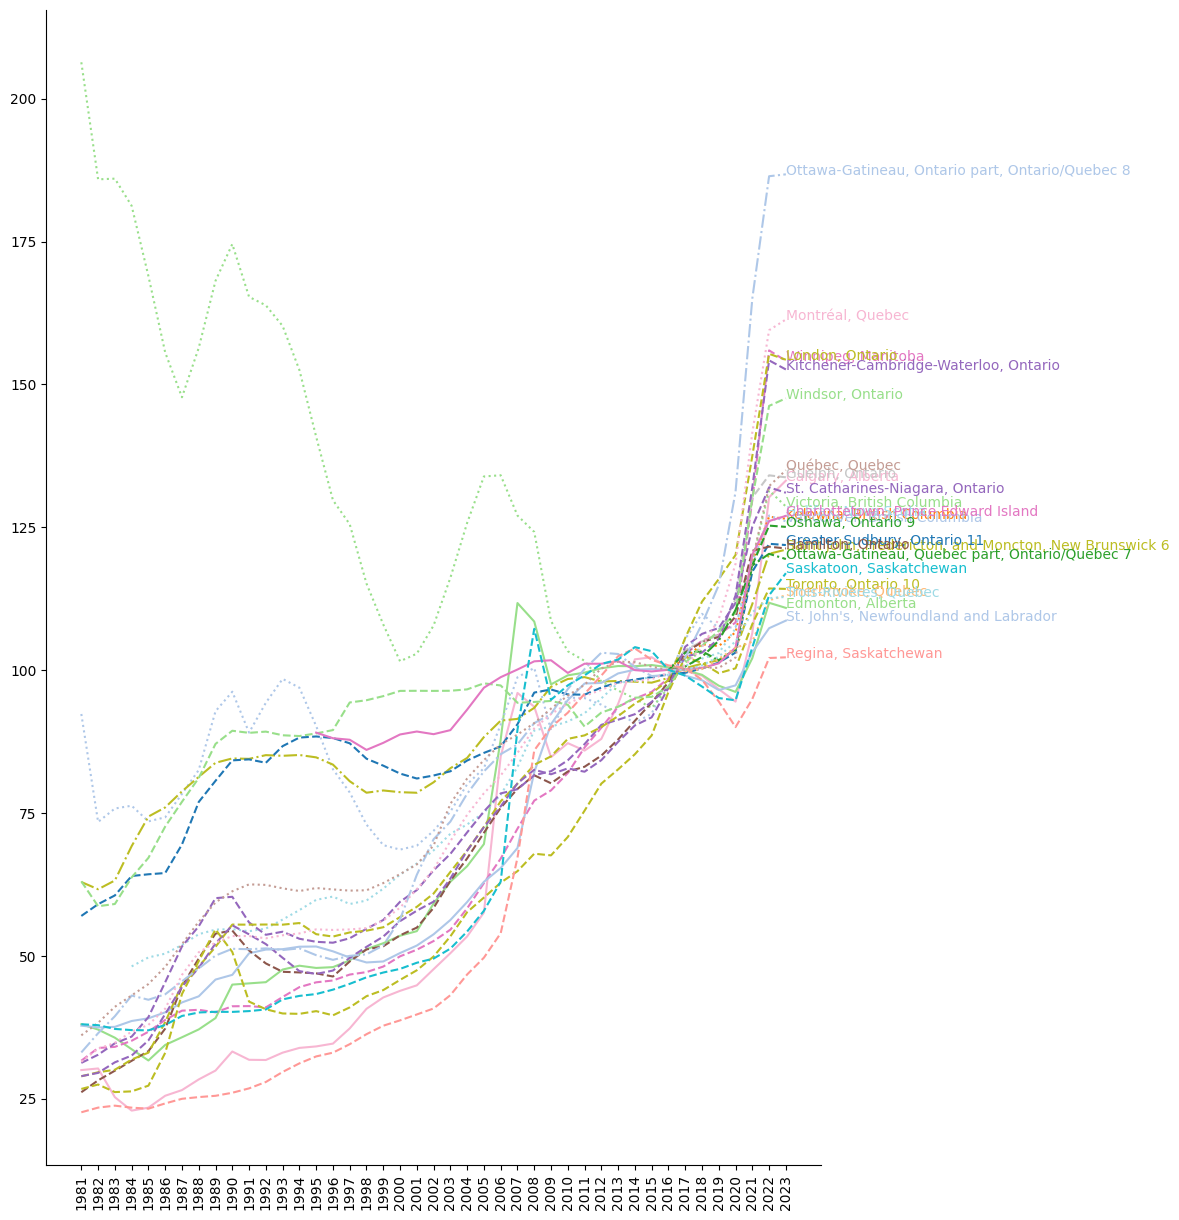

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Define a list of patterns
all_patterns = ['solid', 'dotted', 'dashed', 'dashdot']

# Create a pattern cycle that can loop indefinitely
pattern_cycle = itertools.cycle(all_patterns)

# Assign a pattern to each province
patterns = {province: next(pattern_cycle) for province in cities['province'].unique()}

# Define colors for each city2
# colors = cm.rainbow(np.linspace(0, 1, cities['city2'].nunique()))
colors = plt.get_cmap('tab20')(np.linspace(0, 1, cities['city_prov'].nunique()))
plt.figure(figsize=(10, 15))

for i, (province, province_df) in enumerate(cities.groupby('province')):
    for j, (city_group, city_df) in enumerate(province_df.groupby('city')):
        current_city = city_group
        col_index = np.random.choice(len(colors))
        plt.plot(city_df['year'], city_df['houses'], linestyle=patterns[province], color=colors[col_index], label=current_city)


        # Add city name at the end of each line
        last_year = city_df['year'].values[-1]
        last_price = city_df['houses'].values[-1]
        plt.text(last_year, last_price, current_city, color=colors[col_index])

# # Set the x-axis limits to include all the x-ticks
plt.xticks(rotation=90)

# Add a legend and show the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Remove the box while keeping the axes
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
